In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab
import seaborn

from collections import Counter
from scipy.special import binom

In [11]:
fcs = pd.read_csv('../data/arC9_foldchange.csv')
ss = pd.read_csv('../data/Cas9_merged_stride.csv')

In [12]:
def isnan_str(s):
    if type(s) == str:
        return False
    return np.isnan(s)

secondary_structure_elts_4UN3 = []
secondary_structure_elts_4CMP = []
secondary_structure_elts_4OO8 = []
secondary_structure_elts_4TZ0 = []
for i, row in fcs.iterrows():
    if row['P-value'] < 0.1 and row['Fold Change'] > 2:
        ss_data = ss[ss.PDBResidueNum == row.AA]
        ss_val = np.NAN
        if ss_data.size:
            ss_val = ss_data.SecondaryStructure_4UN3.values[0]
            #if ss_data.LocallyConsistent_4UN3.values[0] or isnan_str(ss_val):
            secondary_structure_elts_4UN3.append(ss_val)
            
            ss_val = ss_data.SecondaryStructure_4CMP.values[0]
            #if ss_data.LocallyConsistent_4CMP.values[0] or isnan_str(ss_val):
            secondary_structure_elts_4CMP.append(ss_val)
            
            ss_val = ss_data.SecondaryStructure_4OO8.values[0]
            #if ss_data.LocallyConsistent_4OO8.values[0] or isnan_str(ss_val):
            secondary_structure_elts_4OO8.append(ss_val)
            
            ss_val = ss_data.SecondaryStructure_4TZ0.values[0]
            #if ss_data.LocallyConsistent_4TZ0.values[0] or isnan_str(ss_val):
            secondary_structure_elts_4TZ0.append(ss_val)


overall_4CMP = Counter(ss.SecondaryStructure_4CMP.values)
overall_4UN3 = Counter(ss.SecondaryStructure_4OO8.values)
overall_4OO8 = Counter(ss.SecondaryStructure_4OO8.values)
overall_4TZ0 = Counter(ss.SecondaryStructure_4TZ0.values)

keys = sorted(overall_4OO8.keys(), key=lambda k: overall_4OO8[k], reverse=True)
overall_4CMP = np.array([float(overall_4CMP[k]) for k in keys])
overall_4UN3 = np.array([float(overall_4UN3[k]) for k in keys])
overall_4OO8 = np.array([float(overall_4OO8[k]) for k in keys])
overall_4TZ0 = np.array([float(overall_4TZ0[k]) for k in keys])

overall_4CMP /= float(overall_4CMP.sum())
overall_4UN3 /= float(overall_4UN3.sum())
overall_4OO8 /= float(overall_4OO8.sum())
overall_4TZ0 /= float(overall_4TZ0.sum())

overall_4CMP_d = dict(zip(keys, overall_4CMP))
overall_4UN3_d = dict(zip(keys, overall_4UN3))
overall_4OO8_d = dict(zip(keys, overall_4OO8))
overall_4TZ0_d = dict(zip(keys, overall_4TZ0))

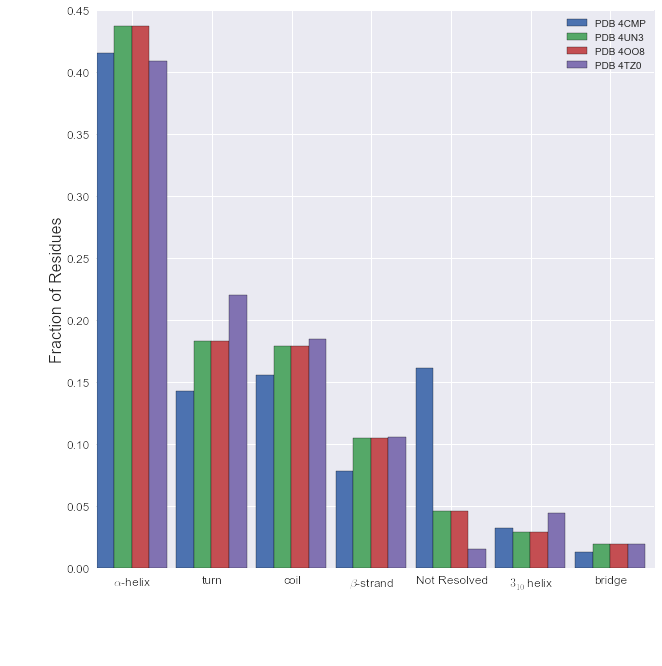

In [13]:
pylab.figure(figsize=(10,10))
xs = np.arange(len(keys))
pretty_names = {'AlphaHelix': r'$\alpha$-helix',
                np.nan: r'Not Resolved',
                'Strand': r'$\beta$-strand',
                'Coil': r'coil',
                'Turn': r'turn',
                '310Helix': r'$3_{10}$ helix',
                'Bridge': r'bridge'}
xticks = [pretty_names[k] for k in keys]
pallete = seaborn.SEABORN_PALETTES['deep']
pylab.bar(xs, overall_4CMP, width=0.22, color=pallete[0], label='PDB 4CMP')
pylab.bar(xs+0.22, overall_4UN3, width=0.22, color=pallete[1], label='PDB 4UN3')
pylab.bar(xs+0.44, overall_4OO8, width=0.22, color=pallete[2], label='PDB 4OO8')
pylab.bar(xs+0.66, overall_4TZ0, width=0.22, color=pallete[3], label='PDB 4TZ0')
pylab.xticks(xs + 0.45, xticks, fontsize=12)
pylab.yticks(fontsize=12)
pylab.ylabel('Fraction of Residues', fontsize=16)
pylab.legend(loc=1)
pylab.savefig('overal_ss_dist.svg')
pylab.show()

In [14]:
def pval(p, count, total):
    """
    P-value calculated assuming we are sampling with replacement from
    an overall distribution where the event of interest (secondary structure)
    has a probability of p and all other events have probability q = 1-p.
    
    Single-tailed P-value for the event that the count is as large as observed
    or larger. Not corrected for multiple hypothesis testing etc. 
    """
    q = 1-p
    pvals = [binom(total, i) * (q**(total-i))*(p**i) for i in range(count, total+1)]
    return np.sum(pvals)
    
def plot_ss_elts(ss_elts, overall_dist, keys=None, pretty_names=None):
    counts = Counter(ss_elts)
    total = len(ss_elts)
    assert total == np.sum(counts.values())

    if not keys:
        keys = sorted(counts.keys(), key=lambda k: counts[k], reverse=True)
    xticks = keys
    if pretty_names:
        xticks = [pretty_names[k] for k in keys]
    xs = np.arange(len(keys))
    vals = np.array([counts[k] for k in keys])
    pvals = [pval(overall_dist[k], vals[i], total) for i, k in enumerate(keys)]
    sig_threshold = 0.05 / len(pvals)
    vsig_threshold = 1e-3 / len(pvals)
    normvals = vals / float(total)

    pylab.bar(xs, normvals, width=0.5)
    for i, p in enumerate(pvals):
        yloc = normvals[i] / 2.0
        top = normvals[i]
        xloc = xs[i] + 0.25
        pylab.text(xloc, top + 0.005, 'P = %.2g' % p, ha='center')
        if p < vsig_threshold:
            pylab.text(xloc, yloc, '**', fontsize=18, ha='center')
        elif p < sig_threshold:
            pylab.text(xloc, yloc, '*', fontsize=18, ha='center')        
    pylab.xticks(xs + 0.25, xticks, fontsize=14)
    pylab.xlim(0, len(keys) - 0.5)
    pylab.ylim(0.0, 0.35)
    


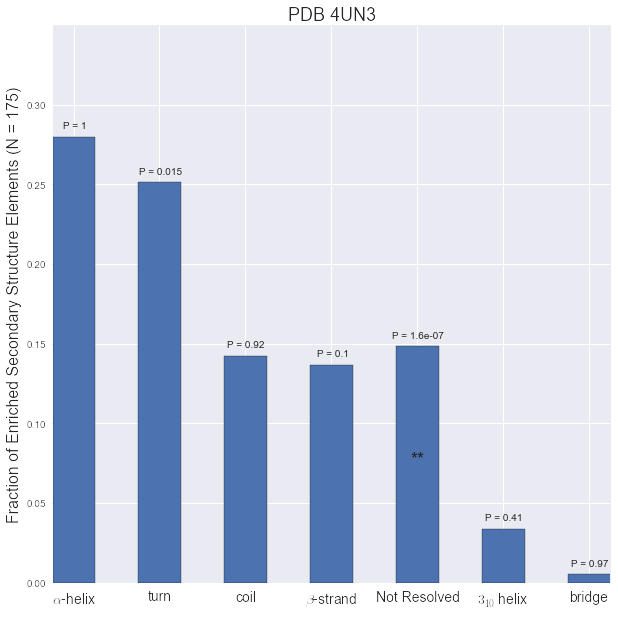

In [15]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4UN3, overall_4UN3_d, keys, pretty_names)
n = len(secondary_structure_elts_4UN3)
pylab.ylabel('Fraction of Enriched Secondary Structure Elements (N = %d)' % n, fontsize=16)
pylab.title('PDB 4UN3', fontsize=18)
pylab.savefig('4UN3_ss_enrichment.svg')
pylab.show()

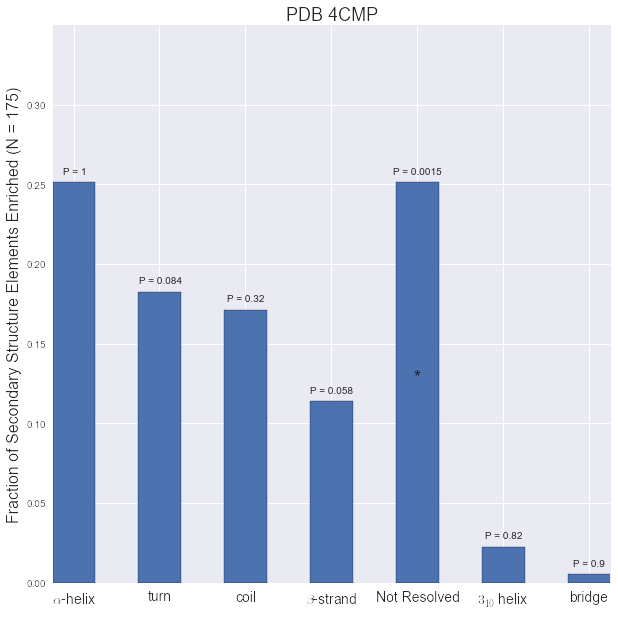

In [16]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4CMP, overall_4CMP_d, keys, pretty_names)
n = len(secondary_structure_elts_4CMP)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched (N = %d)' % n, fontsize=16)
pylab.title('PDB 4CMP', fontsize=18)
pylab.savefig('4CMP_ss_enrichment.svg')
pylab.show()

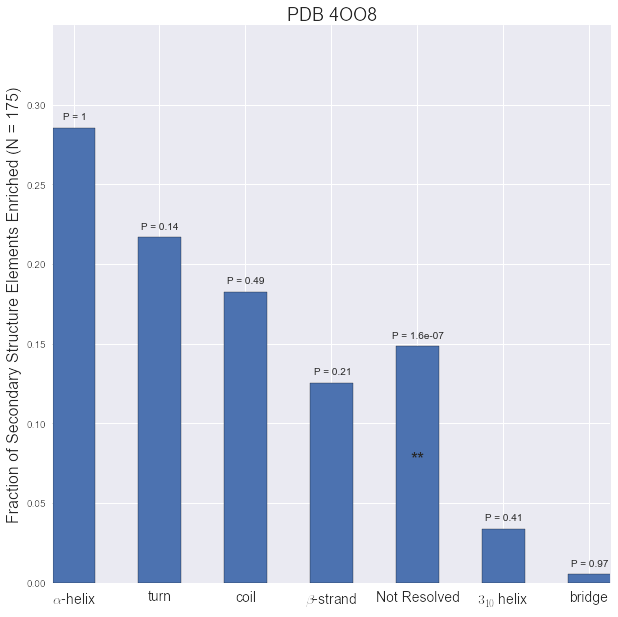

In [17]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4OO8, overall_4OO8_d, keys, pretty_names)
n = len(secondary_structure_elts_4OO8)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched (N = %d)' % n, fontsize=16)
pylab.title('PDB 4OO8', fontsize=18)
pylab.savefig('4OO8_ss_enrichment.svg')
pylab.show()

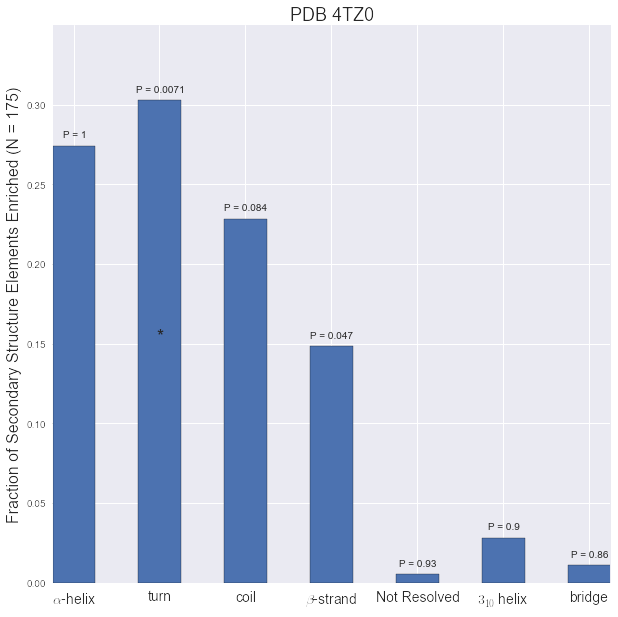

In [18]:
figure = pylab.figure(figsize=(10,10))
plot_ss_elts(secondary_structure_elts_4TZ0, overall_4TZ0_d, keys, pretty_names)
n = len(secondary_structure_elts_4TZ0)
pylab.ylabel('Fraction of Secondary Structure Elements Enriched (N = %d)' % n, fontsize=16)
pylab.title('PDB 4TZ0', fontsize=18)
pylab.savefig('4TZO_ss_enrichment.svg')
pylab.show()